In [14]:
import numpy as np
import keras
import matplotlib.pyplot as plt
from pathlib import Path
from keras.datasets import mnist
from keras import Model
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans
from models.dcec import DCEC
from sklearn.manifold import TSNE
import tensorflow as tf

In [2]:
img_rows, img_cols = 28, 28
batch_size = 128
(mnist_train_data, mnist_train_labels), (mnist_test_data, mnist_test_labels) = mnist.load_data()
mnist_train_data = mnist_train_data.reshape(mnist_train_data.shape[0], img_rows, img_cols, 1)
mnist_train_data = mnist_train_data.astype('float32')
mnist_train_data /= 255
mnist_test_data = mnist_test_data.reshape(mnist_test_data.shape[0], img_rows, img_cols, 1)
mnist_test_data = mnist_test_data.astype('float32')
mnist_test_data /= 255
print(f'MNIST train shape:  {mnist_train_data.shape}')
print(f'MNIST validation shape: {mnist_test_data.shape}')

MNIST train shape:  (60000, 28, 28, 1)
MNIST validation shape: (10000, 28, 28, 1)


In [9]:
dcec = DCEC()
dcec.compile(optimizer='sgd',
              loss='mse')
dcec = dcec.fit(mnist_train_data, 
         mnist_train_data, 
         batch_size=batch_size, 
         epochs=100,
         verbose=1)

Epoch 1/100
 2048/60000 [>.............................] - ETA: 6:25 - loss: 0.1123

KeyboardInterrupt: 

In [4]:
#encoder = Model(inputs=dcec.layers[0].input, outputs=dcec.get_layer(name='dense1').output)
embed = keras.backend.function([dcec.layers[0].input],
                                              [dcec.get_layer(name='dense1').output])
embeddings = np.asarray(embed(mnist_train_data)).squeeze(0)
normalizer = Normalizer(norm='l2')
#embeddings = encoder.predict(mnist_train_data)

print(f'Embeddings shape: {embeddings.shape}')
embeddings = normalizer.fit_transform(embeddings)
clusters = KMeans(n_clusters=10).fit_transform(embeddings)
print(f'Clusters shape: {clusters.shape}')

Embeddings shape: (60000, 10)
Clusters shape: (60000, 10)


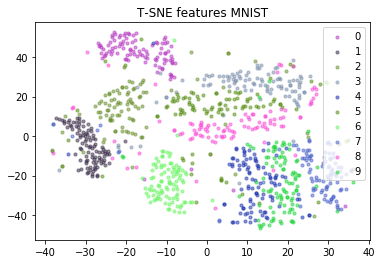

In [42]:
def plot_tsne(data: np.ndarray,
              labels: np.ndarray,
              dataset_name: np.ndarray,
              num_samples_per_class: int = 100) -> None:
    unique_labels = np.unique(labels)
    x_tsne = np.array([])
    for i in range(len(unique_labels)):
        label_ix = np.argwhere(unique_labels[i] == labels).flatten()
        random_labels_ix = np.random.choice(label_ix, num_samples_per_class)
        random_label_data = data[random_labels_ix, :]
        random_label_data = np.reshape(random_label_data, (num_samples_per_class, -1))
        if i == 0:
            x_tsne = random_label_data
        else:
            x_tsne = np.vstack((x_tsne, random_label_data))
    tsne_emb = TSNE(n_components=2).fit_transform(x_tsne)
    for i in range(len(unique_labels)):
        rgb = np.random.rand(3,)
        start_slice = (i)*num_samples_per_class
        stop_slice = (i+1)*num_samples_per_class
        x_plot = tsne_emb[()]
        plt.scatter(tsne_emb[start_slice:stop_slice, 0], tsne_emb[start_slice:stop_slice,1], c=[rgb], s=10, alpha=0.5)
    plt.title(f'T-SNE features {dataset_name}')
    plt.legend(unique_labels)
    plt.show()
    
plot_tsne(mnist_train_data, 
          mnist_train_labels, 
          dataset_name='MNIST',
          num_samples_per_class=100)

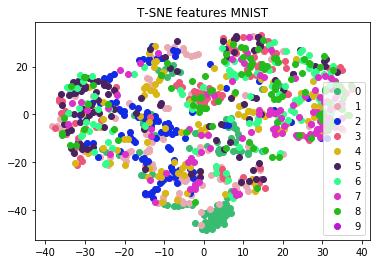

In [6]:
plot_tsne(clusters, 
          mnist_train_labels, 
          dataset_name='MNIST',
          num_samples_per_class=100)

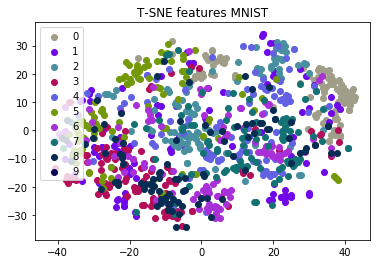

In [7]:
plot_tsne(embeddings, 
          mnist_train_labels, 
          dataset_name='MNIST',
          num_samples_per_class=100)

In [45]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(filters=32, kernel_size=5, strides=2, input_shape=(28, 28, 1), activation='relu', padding='same', name='conv1'))            
model.add(keras.layers.Lambda(lambda x: tf.keras.backend.l2_normalize(x, axis=0)))
model.add(keras.layers.Conv2D(filters=64, kernel_size=5, strides=2, activation='relu', padding='same'))
model.add(keras.layers.Lambda(lambda x: tf.keras.backend.l2_normalize(x, axis=0)))
model.add(keras.layers.Conv2D(filters=128, kernel_size=3, strides=2, activation='relu', padding='valid'))
model.add(keras.layers.Lambda(lambda x: tf.keras.backend.l2_normalize(x, axis=0)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(units=10))
model.add(keras.layers.Lambda(lambda x: tf.keras.backend.l2_normalize(x, axis=0), name='embeddings'))
model.add(keras.layers.Dense(units=1152))
#model.add(keras.layers.Lambda(lambda x: tf.keras.backend.l2_normalize(x, axis=0)))
model.add(keras.layers.Reshape( (3, 3, 128) ))
model.add(keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='valid', activation='relu', name='tp1'))
#model.add(keras.layers.Lambda(lambda x: tf.keras.backend.l2_normalize(x, axis=0)))
model.add(keras.layers.Conv2DTranspose(filters=32, kernel_size=5, strides=2, padding='same', activation='relu', name='tp2'))
#model.add(keras.layers.Lambda(lambda x: tf.keras.backend.l2_normalize(x, axis=0)))
model.add(keras.layers.Conv2DTranspose(filters=1, kernel_size=5, strides=2, padding='same', activation='relu', name='tp3'))
model.compile(optimizer='adam',
                  loss='mse')
model.summary()

model.fit(mnist_train_data, 
          mnist_train_data, 
          batch_size=batch_size, 
          epochs=200,
          verbose=1)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 14, 14, 32)        832       
_________________________________________________________________
lambda_35 (Lambda)           (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 7, 7, 64)          51264     
_________________________________________________________________
lambda_36 (Lambda)           (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 3, 3, 128)         73856     
_________________________________________________________________
lambda_37 (Lambda)           (None, 3, 3, 128)         0         
_________________________________________________________________
flatten_17 (Flatten)         (None, 1152)            

60000/60000 [==============================] - 97s 2ms/step - loss: 0.0109
Epoch 69/200
60000/60000 [==============================] - 97s 2ms/step - loss: 0.0108
Epoch 70/200
60000/60000 [==============================] - 96s 2ms/step - loss: 0.0108
Epoch 71/200
60000/60000 [==============================] - 97s 2ms/step - loss: 0.0108
Epoch 72/200
60000/60000 [==============================] - 97s 2ms/step - loss: 0.0108
Epoch 73/200
60000/60000 [==============================] - 95s 2ms/step - loss: 0.0108
Epoch 74/200
60000/60000 [==============================] - 95s 2ms/step - loss: 0.0108
Epoch 75/200
60000/60000 [==============================] - 96s 2ms/step - loss: 0.0107
Epoch 76/200
60000/60000 [==============================] - 96s 2ms/step - loss: 0.0107
Epoch 77/200
60000/60000 [==============================] - 98s 2ms/step - loss: 0.0107
Epoch 78/200
60000/60000 [==============================] - 96s 2ms/step - loss: 0.0107
Epoch 79/200
60000/60000 [===================

60000/60000 [==============================] - 96s 2ms/step - loss: 0.0099
Epoch 161/200
60000/60000 [==============================] - 96s 2ms/step - loss: 0.0099
Epoch 162/200
60000/60000 [==============================] - 97s 2ms/step - loss: 0.0099
Epoch 163/200
60000/60000 [==============================] - 96s 2ms/step - loss: 0.0099
Epoch 164/200
60000/60000 [==============================] - 96s 2ms/step - loss: 0.0099
Epoch 165/200
60000/60000 [==============================] - 97s 2ms/step - loss: 0.0099
Epoch 166/200
60000/60000 [==============================] - 97s 2ms/step - loss: 0.0099
Epoch 167/200
60000/60000 [==============================] - 97s 2ms/step - loss: 0.0099
Epoch 168/200
60000/60000 [==============================] - 96s 2ms/step - loss: 0.0099
Epoch 169/200
60000/60000 [==============================] - 96s 2ms/step - loss: 0.0099
Epoch 170/200
60000/60000 [==============================] - 97s 2ms/step - loss: 0.0099
Epoch 171/200
60000/60000 [========

In [46]:
#encoder = Model(inputs=dcec.layers[0].input, outputs=dcec.get_layer(name='dense1').output)
#embed = keras.backend.function([dcec_adam.layers[0].input],
#                                              [dcec_adam.get_layer(name='dense1').output])
encoder = Model(inputs=model.input, outputs=model.get_layer(name='embeddings').output)
embeddings = encoder.predict(mnist_test_data)
normalizer = Normalizer(norm='l2')
#embeddings = encoder.predict(mnist_train_data)

print(f'Embeddings shape: {embeddings.shape}')
embeddings = normalizer.fit_transform(embeddings)
clusters = KMeans(n_clusters=10).fit_transform(embeddings)
print(f'Clusters shape: {clusters.shape}')

Embeddings shape: (10000, 10)
Clusters shape: (10000, 10)


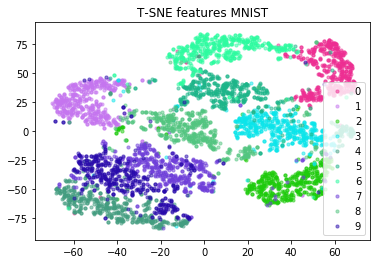

In [47]:
plot_tsne(clusters, 
          mnist_test_labels, 
          dataset_name='MNIST',
          num_samples_per_class=500)

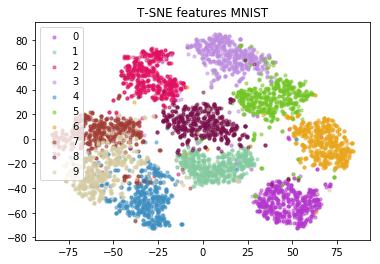

In [48]:
plot_tsne(embeddings, 
          mnist_test_labels, 
          dataset_name='MNIST',
          num_samples_per_class=500)

TypeError: can't multiply sequence by non-int of type 'method'

In [51]:
dcec_adam.save_weights('DCECadam200epochs.h5')